# Weather forecast for Trier by LSTM

We use the description and LSTM algorithm from [here](https://www.rs-online.com/designspark/predicting-weather-using-lstm) to forecast the Microsoft stock price. More theory of LSTM (Long short-term memory recurrent neural network) can also be found there and in its references.


## Importing used libraries

In [14]:
# basics
import pandas as pd # data handling
import numpy as np  # mathematical operations
import os           # manipulating the wd

#plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # date formatting
%matplotlib inline
plt.style.use('seaborn')


# for error calculation
from sklearn.metrics import mean_squared_error

## Importing the cleaned data

In [4]:
msft = pd.read_csv(os.getcwd() + '/data/msft_stock_price_cleaned.csv', index_col=0)
msft.date = pd.to_datetime(msft.date)

## First impression

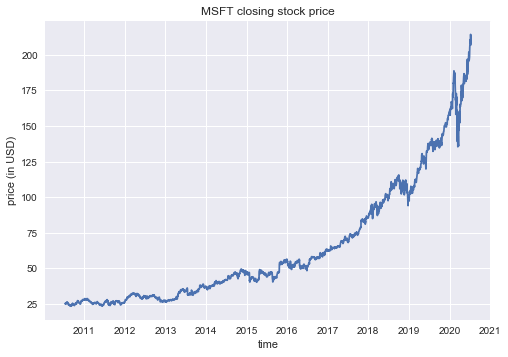

In [15]:
plt.plot('date', 'close', data = msft)
plt.title('MSFT closing stock price')
plt.ylabel('price (in USD)')
plt.xlabel('time')
plt.show()

## The LSTM algorithm

The following algorithm is a modification of [this one](https://github.com/danrustia11/WeatherLSTM) using some ideas from [here](https://www.youtube.com/watch?v=H6du_pfuznE) to use it for forecasting. We defined a tool, which calculates with a variation of LSTM from a time series in a column of a dataframe predictions and forecasts for it.

In [60]:
# modification of (see above):
# LSTM weather prediction demo
# Written by: Dan R 2020

# Core Keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

# For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Other essential libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

def LSTM_tool(dataset, col, testing_days, n_future = 0,
              n_timestamp = 10, n_epochs = 25,
              filter_on = 0 , model_type = 1,
             loss_fct = 'mse'):
    '''
    The LSTM algorithm for time series predictions
    inputs:
        dataset         - a dataframe
        col             - the key of a column of df
        testings_days   - number of testing days, 
        n_timestamp     - number of timestaps,
        n_epochs        - epochs for the algorithm
        filter_on       - = 1 for data conditioning
        model_type      - 1: Single cell, 2: Stacked, 3: bidirectional,
        loss_fct        - type of loss fct
    outputs: prediction, forecast and some measures of accuracy
    '''
    train_days = dataset.shape[0] - testing_days
    if filter_on == 1:
        dataset[col] = medfilt(dataset[col], 3)
        dataset[col] = gaussian_filter1d(dataset[col], 1.2)
    #
    # Set number of training and testing data
    #
    train_set = dataset[:-testing_days].reset_index(drop=True)
    test_set = dataset[-testing_days:].reset_index(drop=True)
    training_set = train_set[col].values.reshape(-1,1)
    testing_set = test_set[col].values.reshape(-1,1)
    #
    # Normalize data first
    #
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    testing_set_scaled = sc.fit_transform(testing_set)
    #
    # preperation: split data into n_timestamp
    #
    def data_split(sequence, n_timestamp):
        X = []
        y = []
        for i in range(len(sequence)):
            end_ix = i + n_timestamp
            if end_ix > len(sequence)-1:
                break
            # i to end_ix as input
            # end_ix as target output
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)

    X_train, y_train = data_split(training_set_scaled, n_timestamp)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test, y_test = data_split(testing_set_scaled, n_timestamp)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    if model_type == 1:
        # Single cell LSTM
        model = Sequential()
        model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
        model.add(Dense(units = 1))
    if model_type == 2:
        # Stacked LSTM
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
    if model_type == 3:
        # Bidirectional LSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
    print(model.summary())
    #
    # Start training
    #
    model.compile(optimizer = 'adam', loss = loss_fct)
    history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
    loss = history.history['loss']
    epochs = range(len(loss))
    #
    # Get predicted data
    #
    y_predicted = model.predict(X_test)
    #
    # 'De-normalize' the data
    #
    y_predicted_descaled = sc.inverse_transform(y_predicted)
    y_train_descaled = sc.inverse_transform(y_train)
    y_test_descaled = sc.inverse_transform(y_test)
    y_pred = y_predicted.ravel()
    y_pred = [round(yx, 2) for yx in y_pred]
    y_tested = y_test.ravel()

    # a future forecast
    future_forecast = []
    if n_future > 0:
        x_input = testing_set_scaled[-n_timestamp:].reshape(1,-1)
        x_input = x_input.reshape((1, n_timestamp,1))
        temp_input=list(x_input)
        temp_input=temp_input[0].tolist()
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat.tolist())
        future_forecast.extend(yhat.tolist())

        for i in range(n_future - 1):
            x_input = array(temp_input[1:])
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_timestamp, 1))
            yhat = model.predict(x_input, verbose = 0)
            temp_input.extend(yhat.tolist())
            temp_input=temp_input[1:]
            future_forecast.extend(yhat.tolist())
        #flatten the future_forecast list
        future_forecast_descaled = sc.inverse_transform(future_forecast)
        #future_forecast_descaled = list(pd.core.common.flatten(future_forecast_descaled))

    return model, y_predicted_descaled, future_forecast_descaled, y_test_descaled, loss


## Used parameters

In [47]:
n_timestamp = 10
# 20% testing data
n_testing = int(msft.shape[0] * .2) + n_timestamp
n_prediction = n_testing - n_timestamp
n_future = 50 # forecast 20 future dates
n_epo = 100

## For easier application

In [21]:
LSTM_application = (lambda x: LSTM_tool(msft, col = x, testing_days = n_testing, 
                                        n_future = n_future, n_timestamp = n_timestamp,
                                        n_epochs = n_epo, filter_on = True, model_type = 2
                                       )
                   )


In [61]:
close_model, close_prediction, close_forecast, close_test, close_loss = LSTM_application('close')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0406
Epoch 2/100
1994/1994 [==============================] - 3s 1ms/step - loss: 2.5969e-04
Epoch 3/100
1994/1994 [==============================] - 5s 3ms/step - loss: 1.8113e-04
Epoch 4/100
1994/1994 [==============================] - 5s 2ms/step - loss: 1.7837e-04
Epoch 5/100
1994/1994 [====

1994/1994 [==============================] - 4s 2ms/step - loss: 1.9580e-05
Epoch 81/100
1994/1994 [==============================] - 4s 2ms/step - loss: 2.2657e-05
Epoch 82/100
1994/1994 [==============================] - 4s 2ms/step - loss: 2.0320e-05
Epoch 83/100
1994/1994 [==============================] - 4s 2ms/step - loss: 2.3792e-05A: 0s - loss: 2.
Epoch 84/100
1994/1994 [==============================] - 4s 2ms/step - loss: 1.9923e-05
Epoch 85/100
1994/1994 [==============================] - 4s 2ms/step - loss: 2.2304e-05
Epoch 86/100
1994/1994 [==============================] - 4s 2ms/step - loss: 1.8342e-05A: 0s - loss: 1.8345e-0
Epoch 87/100
1994/1994 [==============================] - 4s 2ms/step - loss: 1.7687e-05A: 0s - loss: 1.818 - ETA: 0s - loss: 1.8235 - ETA: 0s - loss: 1.800
Epoch 88/100
1994/1994 [==============================] - 6s 3ms/step - loss: 1.6886e-05A: 2s - ETA: 0s - loss: 1.7018e
Epoch 89/100
1994/1994 [==============================] - 4s 2ms/step - lo

## Visualization

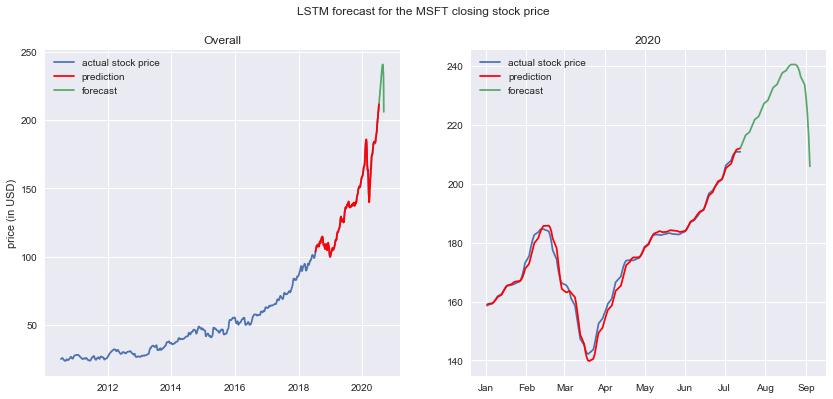

In [120]:
n_future = 40
plt.figure(figsize = (14,6))
plt.suptitle('LSTM forecast for the MSFT closing stock price')

# forecast range
future_ran = pd.bdate_range(start = msft.date.iloc[-1], 
                            end = '2020-09-04')

plt.subplot(1,2,1)
plt.title('Overall')
plt.plot('date', 'close', data = msft, label = 'actual stock price')
plt.plot(msft.date[-n_prediction:],
        close_prediction, color = 'r', label = 'prediction')
plt.plot(future_ran,
        close_forecast[:n_future], label = 'forecast')
plt.ylabel('price (in USD)')
plt.legend()

ax = plt.subplot(1,2,2)
start_index = sum(msft.date >= '2020-01-01')
plt.title('2020')
ax.plot('date', 'close', data = msft[-start_index:], label = 'actual stock price')
ax.plot(msft.date[-start_index:],
        close_prediction[-start_index:], color = 'r', label = 'prediction')
ax.plot(future_ran, close_forecast[:n_future], label = 'forecast')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()


## Evaluation

In [58]:
close_true = np.array(msft.close[-n_prediction:])

rmse = np.sqrt(mean_squared_error(close_true, 
                                  close_prediction))
mape = np.mean(np.abs(close_true - close_prediction.T) 
               / close_true)

print('------- Evaluation for the prediction -------')
print('Squareroot of the mean squared error:   {:.2f}'.format(rmse))
print('Mean absolute percentage error:         {:.2f}%'.format(mape * 100))


------- Evaluation for the prediction -------
Squareroot of the mean squared error:   1.39
Mean absolute percentage error:         0.72%


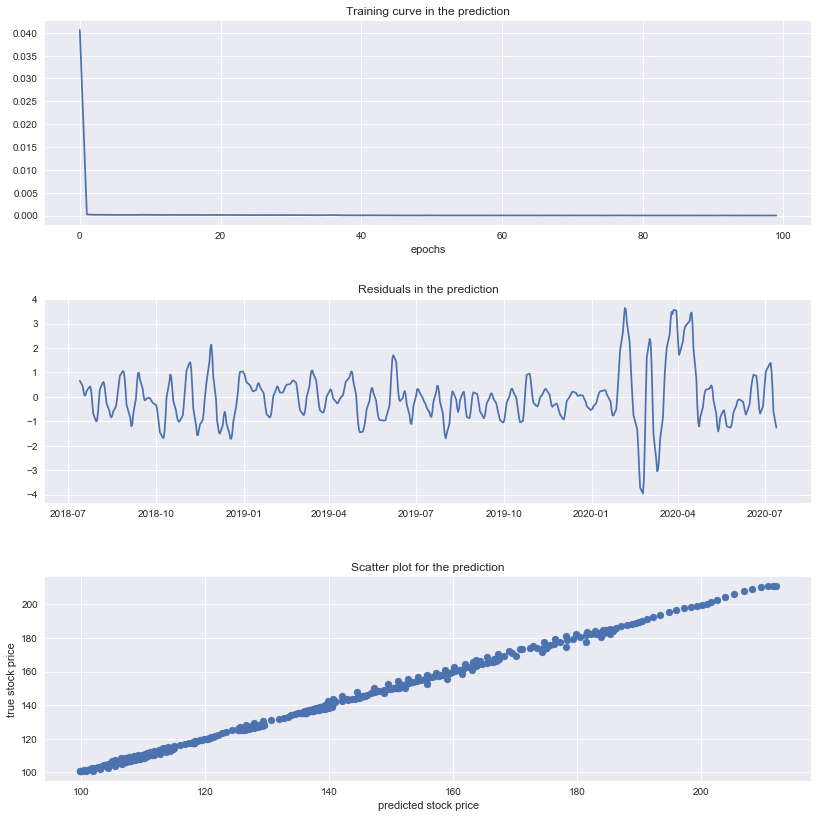

In [69]:
fig = plt.figure(figsize = (12,12))
# trainings curves
plt.subplot(3,1,1)
plt.plot(close_loss)
plt.title('Training curve in the prediction')
plt.xlabel('epochs')

# residuals
plt.subplot(3,1,2)
plt.plot(msft.date[-n_prediction:],(close_true - close_prediction.T)[0])
plt.title('Residuals in the prediction')

# scatter plot
plt.subplot(3,1,3)
plt.scatter(close_prediction,msft.close[-n_prediction:])
plt.title('Scatter plot for the prediction')
plt.xlabel('predicted stock price')
plt.ylabel('true stock price')

fig. tight_layout(pad=3.0)
plt.show()